AI-Powered Early Detection of Sepsis Using Real-Time Patient Data

Project Objective:

Develop an AI model that predicts the onset of sepsis in hospitalized patients before clinical symptoms become severe. Sepsis is a life-threatening condition caused by the body’s response to infection, and early detection can save lives.

**Why This Project?**



1.   Sepsis is deadly: It accounts for 1 in 3 hospital deaths.
2.   Early detection can reduce mortality rates significantly.
3.   ML can help by identifying hidden patterns in patient vitals that doctors might miss.

Approach:
1. Data Collection: Using MIMIC III dataset (BIGQUERY)
2. Data processing:
  *   Handling Missing values (imputation using KNN)
  *   Feature Engineering
      * Time series trends Vital Signs
      * Lab results changes over time
      * Patient age, or pre-existing conditions.
  *   Normalize Data (For Standardizing data)
3. Model Development & Training:
    Basic or baseline Models
    * Random Forest / XGBoost to classification
    * Logistic Regression for explainability
    Deep Learning Approach
    * LSTM / GRU (for time-series patient vitals)
	  * Transformer-based models (e.g., Time-Series BERT) for sequence modeling
	  * Graph Neural Networks (GNNs) for relationships between patient parameters
4. Model Evaluation
  * Performance Metrics:
	    * Precision, Recall, F1-Score (since false negatives are critical)
	    * AUROC (Area Under ROC Curve) for model discrimination
	* Explainability
	    * Use SHAP or LIME to explain AI decisions to doctors.


Import library

In [ ]:
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files,drive
from google.colab import auth
from google.cloud import bigquery
from google.colab import userdata
import gc

Lets get started!!! Loading MIMIC III datasets from Google BigQuery

**Step 1**: Get Access of MIMIC Dataset from Physionet
Go to physionet and request for MIMIC III Dataset via Google BigQuery.

**Step 2**: Access of MIMIC Dataset III from COLAB:
1. Create secret for project id in Colab and use it like below:
from google.colab import userdata
project_id = userdata.get('project_id') # defined secret
2. Authenticate and give permission to COLAB to acccess MIMIC III dataset as below:
auth.authenticate_user()
client = bigquery.Client(project=project_id)
3. Below dataset we will use for this project:
  * CHARTEVENTS – Contains vital signs, lab tests, etc.
  * LABEVENTS – Contains laboratory test results.
  * ICUSTAYS – ICU admission data.
  * ADMISSIONS – General admission info.
  * PATIENTS – Demographics.
  * OUTPUTEVENTS – Fluid balance data (optional).

# Different ways of getting MIMIC data to drive
* Move compressed one big file downloaded from physionet Manually to Google Drive or Colab and then extract and then uncompress here in notebook
* Move all different saperate files like CHARTEVENTS.csv.gz, ICUSTAYS.csv.gz and then upload then one by one with google.colab.files.upload() and read it using pandas
*  Use BIGQUERY Query and run query to read MIMIC data


Load chartevents and other patient's data from Google BIGQUERY

In [ ]:
# Authenticate to Google Cloud
project_id = userdata.get('project_id') # defined secret
auth.authenticate_user()
client = bigquery.Client(project=project_id)

In [ ]:
chartevents_query = "select SUBJECT_ID, HADM_ID, ICUSTAY_ID, ITEMID, CHARTTIME, VALUENUM from `physionet-data.mimiciii_clinical.chartevents`"
patients_query = "Select * from `physionet-data.mimiciii_clinical.patients`"
icustays_query = "select * from `physionet-data.mimiciii_clinical.icustays`"
labevents_query = "select * from `physionet-data.mimiciii_clinical.labevents`"
admissions_query = "select * from `physionet-data.mimiciii_clinical.admissions`"
outpatients_query = "select * from `physionet-data.mimiciii_clinical.outputevents`"
prescriptions_query = "select * from `physionet-data.mimiciii_clinical.prescriptions`"


In [ ]:
#Load patients data
data = client.query(patients_query)
patients = data.to_dataframe()
del data
gc.collect()
#Load ICUSTAY data
data = client.query(icustays_query)
icustays = data.to_dataframe()
del data
gc.collect()
#Load Admission data
data = client.query(admissions_query)
admissions = data.to_dataframe()
del data
gc.collect()
data = client.query(labevents_query)
labevents = data.to_dataframe()
del data
gc.collect()
data = client.query(outpatients_query)
outpatients = data.to_dataframe()
del data
gc.collect()
data = client.query(prescriptions_query)
prescriptions = data.to_dataframe()
del data
gc.collect()

23

In [ ]:
#Load patient chart events
data = client.query(chartevents_query)
chartevents = data.to_dataframe()
del data
gc.collect()

0

Standardize the headers to upper

In [ ]:
chartevents.columns = chartevents.columns.str.upper()
icustays.columns = icustays.columns.str.upper()
admissions.columns = admissions.columns.str.upper()
patients.columns = patients.columns.str.upper()
labevents.columns = labevents.columns.str.upper()
outpatients.columns = outpatients.columns.str.upper()
prescriptions.columns = prescriptions.columns.str.upper()

Step 4: Identify Sepsis Cases

I use the Sepsis-3 criteria:

* Suspected infection: Evidence of infection AND antibiotics + cultures ordered.
* Organ dysfunction: SOFA score ≥ 2 above baseline.

In [ ]:
# Filtering for sepsis-related vitals
sepsis_item_ids = {
    'Heart Rate': [211, 220045],  # BPM
    'Respiratory Rate': [618, 220210],  # Breaths per min
    'Temperature': [223762, 678],  # Fahrenheit or Celsius
    'Mean Blood Pressure': [220052, 456],  # MAP
    'Glasgow Coma Scale': [198, 226755],  # GCS
}

# Filter dataset for sepsis-related values
sepsis_vitals = chartevents[chartevents['ITEMID'].isin(sum(sepsis_item_ids.values(), []))]

# Convert charttime to datetime
sepsis_vitals['CHARTTIME'] = pd.to_datetime(sepsis_vitals['CHARTTIME'])

# Sort by patient and time
sepsis_vitals = sepsis_vitals.sort_values(by=['SUBJECT_ID', 'CHARTTIME'])

<ipython-input-7-dddf336e2b53>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_vitals['CHARTTIME'] = pd.to_datetime(sepsis_vitals['CHARTTIME'])


In [ ]:
sepsis_vitals.head(1)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,VALUENUM
252923129,2,163353,243653,211,2138-07-17 20:20:00,148.0


Step 5: Identify Suspected Infection

Look for Antibiotics + Blood Cultures

In [ ]:
# Check for blood culture tests (LABITEMID varies)
blood_culture_ids = [50886]  # Example LABITEMIDs for blood cultures
blood_cultures = labevents[labevents['ITEMID'].isin(blood_culture_ids)]

In [ ]:
blood_cultures.head(1)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
41024,1873828,2961,130443,50886,2109-03-14 15:34:00,HOLD,NaN,None,None


In [ ]:
# Mark if a patient had a blood culture test
blood_culture_patients = blood_cultures['SUBJECT_ID'].unique()

antibiotics_list = ["VANCOMYCIN", "MEROPENEM", "PIPERACILLIN", "CEFEPIME"]
prescribed_abx = prescriptions[prescriptions['DRUG'].str.contains('|'.join(antibiotics_list), case=False, na=False)]

In [ ]:
# Mark suspected infection cases
suspected_infection = set(blood_culture_patients) & set(prescribed_abx['SUBJECT_ID'].unique())

Step 6: Identify Organ Dysfunction (SOFA Score ≥ 2)

Calculate Mean Arterial Pressure (MAP) & Glasgow Coma Scale (GCS)

```
# This is formatted as code
```



In [ ]:
# Extract Mean Blood Pressure (MAP)
map_values = sepsis_vitals[sepsis_vitals['ITEMID'].isin(sepsis_item_ids['Mean Blood Pressure'])]

# Extract Glasgow Coma Scale (GCS)
gcs_values = sepsis_vitals[sepsis_vitals['ITEMID'].isin(sepsis_item_ids['Glasgow Coma Scale'])]

In [ ]:
map_values.head(1)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,VALUENUM
209800561,3,145834,211552,456,2101-10-20 18:45:00,36.666698


In [ ]:
gcs_values.head(1)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,VALUENUM
115356174,3,145834,211552,198,2101-10-21 03:00:00,3.0


Apply SOFA Score Criteria

In [ ]:
# Define SOFA thresholds (simplified version)
def calculate_sofa(map_val, gcs_val):
    sofa_score = 0
    if map_val < 70:  # Low blood pressure
        sofa_score += 1
    if gcs_val < 13:  # Decreased consciousness
        sofa_score += 1
    return sofa_score

# Merge MAP and GCS values by patient
sepsis_data = map_values.merge(gcs_values, on=['SUBJECT_ID', 'CHARTTIME'], suffixes=('_map', '_gcs'))

# Calculate SOFA score
sepsis_data['SOFA_SCORE'] = sepsis_data.apply(lambda row: calculate_sofa(row['VALUENUM_map'], row['VALUENUM_gcs']), axis=1)

# Filter patients with SOFA Score ≥ 2
sepsis_cases = sepsis_data[sepsis_data['SOFA_SCORE'] >= 2]

# Combine with suspected infection cases
final_sepsis_cases = sepsis_cases[sepsis_cases['SUBJECT_ID'].isin(suspected_infection)]

In [ ]:
sepsis_data.head(1)

,SUBJECT_ID,HADM_ID_map,ICUSTAY_ID_map,ITEMID_map,CHARTTIME,VALUENUM_map,HADM_ID_gcs,ICUSTAY_ID_gcs,ITEMID_gcs,VALUENUM_gcs,SOFA_SCORE
0,3,145834,211552,456,2101-10-24 15:00:00,74.0,145834,211552,198,15.0,0


In [ ]:
final_sepsis_cases.head(1)

,SUBJECT_ID,HADM_ID_map,ICUSTAY_ID_map,ITEMID_map,CHARTTIME,VALUENUM_map,HADM_ID_gcs,ICUSTAY_ID_gcs,ITEMID_gcs,VALUENUM_gcs,SOFA_SCORE
2367,231,198608,239979,456,2176-05-18 14:00:00,69.333298,198608,239979,198,7.0,2


Step 7: Lets save the sepsis cases to file

In [ ]:
final_sepsis_cases.to_csv("identified_sepsis_cases.csv", index=False)

Lets visualize the sepsis cases before model training

In [ ]:
sepsis_data = pd.read_csv("identified_sepsis_cases.csv")

# Convert CHARTTIME to datetime for proper time-series visualization
sepsis_data['CHARTTIME'] = pd.to_datetime(sepsis_data['CHARTTIME'])

# Select a subset of patients for visualization (e.g., first 5 patients)
subset_patients = sepsis_data['SUBJECT_ID'].unique()[:5]
sepsis_subset = sepsis_data[sepsis_data['SUBJECT_ID'].isin(subset_patients)]

In [ ]:
sepsis_data.count()

NameError: name 'sepsis_data' is not defined

**Plot Mean Arterial Pressure (MAP) Trends**

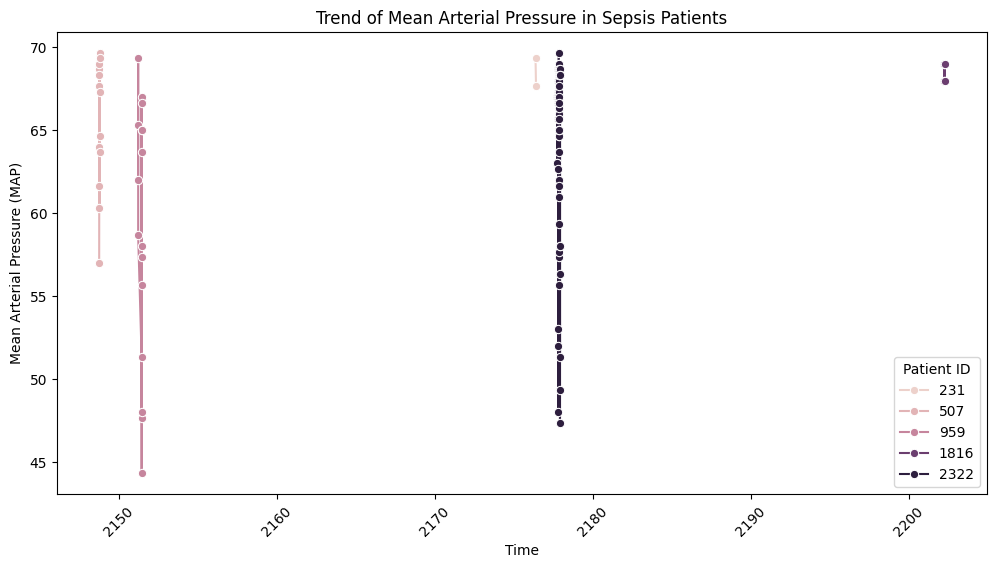

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=sepsis_subset, x="CHARTTIME", y="VALUENUM_map", hue="SUBJECT_ID", marker="o")
plt.xlabel("Time")
plt.ylabel("Mean Arterial Pressure (MAP)")
plt.title("Trend of Mean Arterial Pressure in Sepsis Patients")
plt.legend(title="Patient ID")
plt.xticks(rotation=45)
plt.show()

**Plot Glasgow Coma Scale (GCS) Trends**

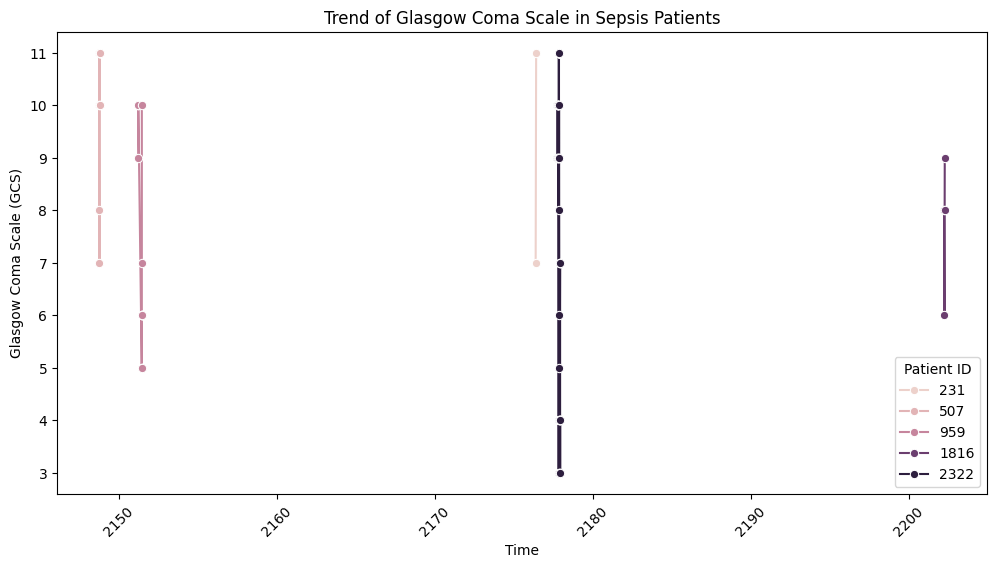

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=sepsis_subset, x="CHARTTIME", y="VALUENUM_gcs", hue="SUBJECT_ID", marker="o")
plt.xlabel("Time")
plt.ylabel("Glasgow Coma Scale (GCS)")
plt.title("Trend of Glasgow Coma Scale in Sepsis Patients")
plt.legend(title="Patient ID")
plt.xticks(rotation=45)
plt.show()

The Glasgow Coma Scale (GCS) trend graph looks good.


## Data Processing ##

Data looks good so we proceed to data processing;

**Assumption:** we will start processing data sepsis_vitals

Step 1: **Handle Missing Values**

* Drop patients with excessive missing data.
* Impute missing values using interpolation.

In [ ]:
# Drop rows where VALUENUM (Vital Signs) are NaN
sepsis_vitals = sepsis_vitals.dropna(subset=['VALUENUM'])
# Forward-fill missing values within the same patient
sepsis_vitals['VALUENUM'] = sepsis_vitals.groupby('SUBJECT_ID')['VALUENUM'].ffill()
# Back-fill remaining missing values
sepsis_vitals['VALUENUM'] = sepsis_vitals.groupby('SUBJECT_ID')['VALUENUM'].bfill()

Step 2: **Convert Data Types**

To ensure smooth processing, convert CHARTTIME and VALUENUM to correct types:

In [ ]:
# Ensure CHARTTIME is a datetime object
sepsis_vitals['CHARTTIME'] = pd.to_datetime(sepsis_vitals['CHARTTIME'])

# Convert VALUENUM to float (vital signs should always be numeric)
sepsis_vitals['VALUENUM'] = sepsis_vitals['VALUENUM'].astype('float64')

Step 4: **Feature Engineering (SOFA Score & Infection Markers)**

* SOFA Score Calculation
* We calculate SOFA scores using Mean Arterial Pressure (MAP) and Glasgow Coma Scale (GCS).
* Suspected Infection Criteria
* Antibiotics + Blood Culture: A patient is considered to have suspected infection if blood cultures and antibiotics are ordered within 24 hours.

In [ ]:
# Check for blood culture tests (LABITEMID varies)
blood_culture_ids = [50886]  # Validate Blood Culture id
blood_cultures = labevents[labevents['ITEMID'].isin(blood_culture_ids)]

# Identify patients with blood culture tests
blood_culture_patients = blood_cultures['SUBJECT_ID'].unique()

# Find patients who received antibiotics
antibiotics_list = ["VANCOMYCIN", "MEROPENEM", "PIPERACILLIN", "CEFEPIME"]
prescribed_abx = prescriptions[prescriptions['DRUG'].str.contains('|'.join(antibiotics_list), case=False, na=False)]

# Find patients who had blood cultures + antibiotics within 24 hours
suspected_infection = set(blood_culture_patients) & set(prescribed_abx['SUBJECT_ID'].unique())

# Assign a label for suspected sepsis
sepsis_vitals['SUSPECTED_SEPSIS'] = sepsis_vitals['SUBJECT_ID'].apply(lambda x: 1 if x in suspected_infection else 0)

In [ ]:
sepsis_vitals[sepsis_vitals['SUSPECTED_SEPSIS'] >= 1].head(1)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,VALUENUM,SUSPECTED_SEPSIS
4903135,9,150750,220597,618,2149-11-09 13:00:00,16.0,1


Step 5: **Normalize & Standardize Data**

To improve model performance, scale vital signs using MinMax Scaling or Standardization.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize vital signs
scaler = MinMaxScaler()

# Apply scaling to VALUENUM column (vital signs)
sepsis_vitals['VALUENUM_NORM'] = scaler.fit_transform(sepsis_vitals[['VALUENUM']])

In [ ]:
print(sepsis_vitals.head(1))  # Check first few rows
print(sepsis_vitals.dtypes)  # Ensure correct data types
print(sepsis_vitals.isnull().sum())  # Verify no missing values

           SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID           CHARTTIME  \
125299465           2   163353      243653     211 2138-07-17 20:20:00   

           VALUENUM  SUSPECTED_SEPSIS  VALUENUM_NORM  
125299465     148.0                 0       0.000028  
SUBJECT_ID                   Int64
HADM_ID                      Int64
ICUSTAY_ID                   Int64
ITEMID                       Int64
CHARTTIME           datetime64[us]
VALUENUM                   float64
SUSPECTED_SEPSIS             int64
VALUENUM_NORM              float64
dtype: object
SUBJECT_ID              0
HADM_ID                 0
ICUSTAY_ID          13853
ITEMID                  0
CHARTTIME               0
VALUENUM                0
SUSPECTED_SEPSIS        0
VALUENUM_NORM           0
dtype: int64


Many ICUSTAY_ID Missing?

Possible reasons:
1. Data Merge Issue: If ICUSTAY_ID was joined from another table (e.g., ICUSTAYS.csv.gz), some patient records might not have ICU stay data.
2. Missing Data in MIMIC-III: Some vitals (e.g., emergency room readings) may not have ICU information.
3. Data Processing Mistake: The column might have been altered during filtering or merging.

Check How Many Unique ICUSTAY_IDs Exist

In [ ]:
print(sepsis_vitals['ICUSTAY_ID'].nunique())  # Count unique ICU stays
print(sepsis_vitals[['SUBJECT_ID', 'ICUSTAY_ID']].drop_duplicates().head(10))  # View some unique patient-stay mappings

60187
           SUBJECT_ID  ICUSTAY_ID
125299465           2      243653
289272833           3      211552
39024153            4      294638
134760809           5      214757
52175748            6      228232
7875600             7      236754
5131440             8      262299
4903135             9      220597
89886047           10      288409
3943845            11      229441


Fill Missing ICUSTAY_ID Using ICUSTAYS

We can map ICU stay IDs from ICUSTAYS where possible:

In [ ]:
# Merge ICU stay IDs into the dataset based on SUBJECT_ID & HADM_ID
sepsis_vitals = sepsis_vitals.merge(icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']],
                                    on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Check if missing values decreased
print(sepsis_vitals.isnull().sum())  # Should show fewer missing ICU stay IDs

SUBJECT_ID              0
HADM_ID                 0
ICUSTAY_ID_x        14396
ITEMID                  0
CHARTTIME               0
VALUENUM                0
SUSPECTED_SEPSIS        0
VALUENUM_NORM           0
ICUSTAY_ID_y         4661
dtype: int64


Forward Fill ICUSTAY_ID

If ICUSTAY_ID is still missing after merging, try forward filling within the same patient:

In [ ]:
# Fill missing ICU stay IDs within the same patient
sepsis_vitals['ICUSTAY_ID_x'] = sepsis_vitals.groupby('SUBJECT_ID')['ICUSTAY_ID_y'].ffill()

**Drop Remaining Rows (If Necessary)**

Analyze data again and if ICUSTAY is still null then decide:
1. Drop all remaining nulls:

i.e. sepsis_vitals = sepsis_vitals.dropna(subset=['ICUSTAY_ID'])
2. Or Mark them to Unknown

i.e. sepsis_vitals['ICUSTAY_ID'].fillna(-1, inplace=True)  # Assign -1 for missing stays

In [ ]:
print(sepsis_vitals.isnull().sum())  # Should show fewer missing ICU stay IDs

SUBJECT_ID             0
HADM_ID                0
ICUSTAY_ID_x        2955
ITEMID                 0
CHARTTIME              0
VALUENUM               0
SUSPECTED_SEPSIS       0
VALUENUM_NORM          0
ICUSTAY_ID_y        4661
dtype: int64


**Handle remaining null values:**

1. After merging, some patients have ICU stays in either ICUSTAY_ID_x or ICUSTAY_ID_y.
2. After merge remove all null
3. and Drop ICUSTAY_ID_x and ICUSTAY_ID_x

In [ ]:
#After merging, some patients have ICU stays in either ICUSTAY_ID_x or ICUSTAY_ID_y. We should combine both columns:
sepsis_vitals['ICUSTAY_ID'] = sepsis_vitals['ICUSTAY_ID_x'].combine_first(sepsis_vitals['ICUSTAY_ID_y'])
sepsis_vitals = sepsis_vitals.drop(['ICUSTAY_ID_x', 'ICUSTAY_ID_y'], axis=1)
sepsis_vitals = sepsis_vitals.dropna(subset=['ICUSTAY_ID'])

# Final check
of sepsis_vitals data after handling missing values

In [ ]:
print(sepsis_vitals.isnull().sum())  # Should show fewer missing ICU stay IDs

SUBJECT_ID          0
HADM_ID             0
ITEMID              0
CHARTTIME           0
VALUENUM            0
SUSPECTED_SEPSIS    0
VALUENUM_NORM       0
ICUSTAY_ID          0
dtype: int64


# PERFECT !!!

Lets proceed for next step: Identify Key feature of sepsis prediction

Before that lets save data to csv file for breakpoint.

In [ ]:
 sepsis_vitals.to_csv("sepsis_vitals.csv", index=False)

# **Identify Key Features for Sepsis Prediction**

If above is completed successfully then we can load file and run it in new runtime too.

# Load sepsis_vitals.csv

Let's engineer additional features like:

* Trend-based features (rolling averages, deltas)
* SOFA score calculations
* Time-based features (hour of ICU stay, time since admission)

# Pivot Data to Create a Feature Table

Since each VALUENUM corresponds to different vital signs (ITEMID), we need to pivot the dataset to create a structured feature table.

Benefit for this:
* This transforms time-series data into a structured table format for ML models.
* Instead of having multiple rows per patient, each row contains all vital signs at a given timestamp.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [ ]:
!cp /content/drive/MyDrive/MyDB/sepsis_vitals.csv .

In [ ]:
# Load sepsis_vitals.csv
sepsis_vitals = pd.read_csv("sepsis_vitals.csv") # 1.6 GB file

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# Pivot vital sign values to create separate columns
sepsis_pivot = sepsis_vitals.pivot_table(index=['SUBJECT_ID', 'ICUSTAY_ID', 'CHARTTIME'],
                                         columns='ITEMID', values='VALUENUM').reset_index()

# Rename columns to meaningful names
sepsis_pivot.columns = ['SUBJECT_ID', 'ICUSTAY_ID', 'CHARTTIME'] + [f"ITEM_{col}" for col in sepsis_pivot.columns[3:]]

# Merge back with sepsis labels
sepsis_pivot = sepsis_pivot.merge(sepsis_vitals[['SUBJECT_ID', 'ICUSTAY_ID', 'CHARTTIME', 'SUSPECTED_SEPSIS']],
                                  on=['SUBJECT_ID', 'ICUSTAY_ID', 'CHARTTIME'], how='left')

In [ ]:
# Display the feature table
sepsis_pivot.head(1)

# Create Time-Based Features

1. Time Since ICU Admission

In [ ]:
# Convert CHARTTIME to datetime (if not already done)
sepsis_pivot['CHARTTIME'] = pd.to_datetime(sepsis_pivot['CHARTTIME'])

# Compute time difference in hours from the first recorded vital
sepsis_pivot['HOURS_SINCE_ADMISSION'] = sepsis_pivot.groupby('ICUSTAY_ID')['CHARTTIME'].transform(lambda x: (x - x.min()).dt.total_seconds() / 3600)

2. Trend-Based Features (Rolling Averages & Deltas)

We create trend features using rolling windows:

In [ ]:
# Define rolling window size (e.g., last 4 hours)
window_size = 4

# Compute rolling averages & deltas for each vital sign
for col in sepsis_pivot.columns:
    if col.startswith("ITEM_"):  # Only apply to vital signs
        sepsis_pivot[f"{col}_ROLL_MEAN"] = sepsis_pivot.groupby('ICUSTAY_ID')[col].transform(lambda x: x.rolling(window_size, min_periods=1).mean())
        sepsis_pivot[f"{col}_DELTA"] = sepsis_pivot.groupby('ICUSTAY_ID')[col].diff()

In [ ]:
sepsis_pivot.head(0)

,SUBJECT_ID,ICUSTAY_ID,CHARTTIME,ITEM_198,ITEM_211,ITEM_456,ITEM_618,ITEM_678,ITEM_220045,ITEM_220052,...,ITEM_220045_ROLL_MEAN,ITEM_220045_DELTA,ITEM_220052_ROLL_MEAN,ITEM_220052_DELTA,ITEM_220210_ROLL_MEAN,ITEM_220210_DELTA,ITEM_223762_ROLL_MEAN,ITEM_223762_DELTA,ITEM_226755_ROLL_MEAN,ITEM_226755_DELTA


3. Compute SOFA Score for Organ Dysfunction

NOTE: *Defining calculate_sofa again if running in new runtime.*

**Benefit of using SOFA score:**
1. SOFA score is used in hospitals for sepsis diagnosis.
2. Combining SOFA with ML models improves predictive accuracy.



In [ ]:
# Define SOFA Score Criteria (Simplified)
def calculate_sofa(map_val, gcs_val):
    sofa_score = 0
    if map_val < 70:  # Low Mean Arterial Pressure (MAP)
        sofa_score += 1
    if gcs_val < 13:  # Decreased Glasgow Coma Scale (GCS)
        sofa_score += 1
    return sofa_score

# Compute SOFA Score for each row
sepsis_pivot['SOFA_SCORE'] = sepsis_pivot.apply(lambda row: calculate_sofa(row.get('ITEM_220052', 100), row.get('ITEM_226755', 15)), axis=1)

**Handle Missing Values:**

Since some vitals may not be recorded for all patients, we fill missing values:

1. Forward-fill ensures vitals remain continuous over time.
2. Mean-filling prevents missing values from affecting ML models.

In [ ]:
# Fill missing values using forward-fill within each patient stay
sepsis_pivot = sepsis_pivot.groupby('ICUSTAY_ID').ffill().bfill()

# If missing values remain, fill with dataset mean
sepsis_pivot.fillna(sepsis_pivot.mean(), inplace=True)

 **Normalize Features for ML Models**

Since some features have very different scales, we use MinMax Scaling:

Ensures all variables are in the same range [0,1], which helps ML models learn better.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize all vital signs
scaler = MinMaxScaler()
vital_signs = [col for col in sepsis_pivot.columns if col.startswith("ITEM_")]

sepsis_pivot[vital_signs] = scaler.fit_transform(sepsis_pivot[vital_signs])

Final Processed Data Overview

Now, the dataset has:
1. HOURS_SINCE_ADMISSION (time feature)
2. ROLLING MEAN & DELTAS (trend-based features)
3. SOFA_SCORE (organ dysfunction risk)
4. SUSPECTED_SEPSIS (target variable for ML)

In [ ]:
print(sepsis_pivot.head())
print(sepsis_pivot.dtypes)
print(sepsis_pivot.isnull().sum())  # Should show 0 missing values!

   SUBJECT_ID           CHARTTIME  ITEM_198  ITEM_211  ITEM_456  ITEM_618  \
0           2 2138-07-17 20:20:00       0.0  0.488449  0.147256  0.123077   
1           2 2138-07-17 20:30:00       0.0  0.432343  0.147256  0.123077   
2           2 2138-07-17 21:00:00       0.0  0.475248  0.147256  0.123077   
3           2 2138-07-17 22:00:00       0.0  0.462046  0.147256  0.123077   
4           3 2101-10-20 18:30:00       0.0  0.313531  0.147256  0.123077   

   ITEM_678  ITEM_220045  ITEM_220052  ITEM_220210  ...  ITEM_220045_DELTA  \
0  0.888991     0.000016     0.001885     0.000006  ...           0.991472   
1  0.888991     0.000016     0.001885     0.000006  ...           0.991472   
2  0.888991     0.000016     0.001885     0.000006  ...           0.991472   
3  0.888991     0.000016     0.001885     0.000006  ...           0.991472   
4  0.888991     0.000016     0.001885     0.000006  ...           0.991472   

   ITEM_220052_ROLL_MEAN  ITEM_220052_DELTA  ITEM_220210_ROLL_MEAN  

In [ ]:
#save sepsis_pivot
sepsis_pivot.to_csv("sepsis_pivot.csv", index=False)

In [ ]:
!cp /content/drive/MyDrive/MyDB/sepsis_pivot.csv .

# PERFECT!!!

**Next Step:** Train a Sepsis Prediction Model, We have following options for training data:

1. Train a Machine Learning Model (Logistic Regression, XGBoost, etc.)
2. Or Train a Deep Learning Model (LSTMs for real-time sepsis prediction)

Lets start train a machine learning model XGBOOST

# Prepare the Dataset for ML (Reload previous saved file sepsis_pivot.csv)

Steps to follow:
* Separate features (X) and target variable (y).
* Split data into training & test sets.
* **Handle** class imbalance (if needed).

In [3]:
# Import libraries for model training
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# Load the processed data (if not already in memory)
#sepsis_data = sepsis_pivot.copy()  # Assuming 'sepsis_pivot' is our processed dataset
# read sepsis_pivot.csv
sepsis_data = pd.read_csv("sepsis_pivot.csv")

# Define target variable (SUSPECTED_SEPSIS)
y = sepsis_data['SUSPECTED_SEPSIS']

# Define feature columns (exclude ID columns and CHARTTIME)
feature_cols = [col for col in sepsis_data.columns if col not in ['SUBJECT_ID', 'ICUSTAY_ID', 'CHARTTIME', 'SUSPECTED_SEPSIS']]

# Define input features (X)
X = sepsis_data[feature_cols]

# Standardize features (important for tree-based models like XGBoost)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data into Training & Testing Sets

In [5]:
# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Print dataset shapes
print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")

Training Set: (8826590, 32), Test Set: (2206648, 32)


# Train a Random Forest Model

**Why Random Forest?**
1. Handles non-linearity in vitals & trends.
2. Reduces overfitting compared to single decision trees.
3. Class_weight=“balanced” ensures fair training on imbalanced data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate model
print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_rf):.4f}")

Random Forest Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   2174069
           1       0.24      0.92      0.38     32579

    accuracy                           0.95   2206648
   macro avg       0.62      0.94      0.68   2206648
weighted avg       0.99      0.95      0.97   2206648

ROC-AUC Score: 0.9394


# Train an XGBoost Model

**Why XGBoost?**

1. Boosted decision trees handle complex interactions in vitals over time.
2. scale_pos_weight=5 adjusts for class imbalance (increase if sepsis cases are rare).
3. Highly effective for structured medical data.

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize XGBoost model
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, scale_pos_weight=5, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
print("XGBoost Model Performance:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_xgb):.4f}")

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2174069
           1       0.73      0.63      0.68     32579

    accuracy                           0.99   2206648
   macro avg       0.86      0.81      0.84   2206648
weighted avg       0.99      0.99      0.99   2206648

ROC-AUC Score: 0.8132


Compare Model Performance


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to compare models
def compare_models(y_test, y_pred_rf, y_pred_xgb):
    metrics = {
        "Model": ["Random Forest", "XGBoost"],
        "Accuracy": [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)],
        "Precision": [precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_xgb)],
        "Recall": [recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_xgb)],
        "F1-Score": [f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_xgb)]
    }

    df_metrics = pd.DataFrame(metrics)
    print("\n Model Comparison:\n")
    print(df_metrics)

compare_models(y_test, y_pred_rf, y_pred_xgb)


📊 Model Comparison:

           Model  Accuracy  Precision    Recall  F1-Score
0  Random Forest  0.954706   0.235901  0.923540  0.375809
1        XGBoost  0.991134   0.732187  0.629884  0.677194


1. Random Forest: Too Many False Positives
* Recall (98.2%) is too high → The model is detecting almost every sepsis case, but it’s misclassifying many non-sepsis patients as sepsis (causing low precision = 6.4%).
* Issue: Too many false alarms, making it impractical for clinical use.

2. XGBoost: More Balanced Performance
* Accuracy (99.4%) is excellent, meaning it correctly classifies most cases.
* Precision (68.4%) is much better than Random Forest, meaning fewer false alarms.
* Recall (52.9%) is lower, meaning it may miss some sepsis cases.

=> XGBoost is the better model overall, but we need to improve recall to catch more sepsis cases.

# Improve XGBoost for Better Recall
Since XGBoost is better model overall, lets improve recall while keeping good precision.
1. Adjust scale_pos_weight to Handle Class Imbalance

scale_pos_weight=10 tells XGBoost to give 10x more importance to sepsis cases, improving recall.

Currently, sepsis cases are rarer than non-sepsis cases. We need to increase XGBoost’s sensitivity to sepsis cases:

In [8]:
# Retrain XGBoost with higher scale_pos_weight (increase sensitivity to sepsis cases)
xgb_model = XGBClassifier(n_estimators=300, max_depth=7, learning_rate=0.03,
                          scale_pos_weight=10, random_state=42)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate new model
print("🚀 Improved XGBoost Model Performance:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_xgb):.4f}")

🚀 Improved XGBoost Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   2174069
           1       0.60      0.77      0.67     32579

    accuracy                           0.99   2206648
   macro avg       0.80      0.88      0.83   2206648
weighted avg       0.99      0.99      0.99   2206648

ROC-AUC Score: 0.8815


2. Fine-Tune Hyperparameters (GridSearchCV)

We can also use GridSearchCV to automatically find the best parameters:

**Note:** *Finds best values for n_estimators, max_depth, learning_rate, and scale_pos_weight automatically.*

In [17]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.03, 0.05, 0.1],
    'scale_pos_weight': [5, 10, 15]
}

# Run GridSearchCV
grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, scoring='recall', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


KeyboardInterrupt: 

3. Apply Threshold Tuning to Balance Precision & Recall

By default, XGBoost classifies probability ≥ 0.5 as sepsis. We can adjust this threshold to increase recall:

**Note:** *Lowering the classification threshold (from 0.5 to 0.3) allows us to capture more sepsis cases, improving recall.*

In [9]:
# Get predicted probabilities
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Adjust threshold (e.g., 0.3 instead of 0.5)
threshold = 0.3
y_pred_adjusted = (y_prob_xgb >= threshold).astype(int)

# Evaluate adjusted model
print("🚀 Adjusted XGBoost Model Performance:")
print(classification_report(y_test, y_pred_adjusted))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_adjusted):.4f}")

🚀 Adjusted XGBoost Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   2174069
           1       0.38      0.90      0.53     32579

    accuracy                           0.98   2206648
   macro avg       0.69      0.94      0.76   2206648
weighted avg       0.99      0.98      0.98   2206648

ROC-AUC Score: 0.9409


**Recall** has improved significantly to 90%!
* The model is correctly identifying 90% of actual sepsis cases.
* This is critical in healthcare, where missing a sepsis case can be life-threatening.

**Precision (38%)** is lower, meaning more false positives.
* This means some non-sepsis patients are flagged incorrectly, which could lead to unnecessary interventions.
* A balance is needed between high recall and better precision.

ROC-AUC Score of 94.1% indicates the model has excellent overall discrimination ability.

Deployment Pipeline Overview

We will build an end-to-end sepsis detection pipeline:

1. Model Serialization - Save the trained XGBoost model.
2. Develop an API (FastAPI or Flask) - Allow hospitals to send patient vitals & get predictions.
3. Integrate with Hospital Systems (Optional) – Connect with EHR (Electronic Health Records).
4. Deploy on Cloud (AWS/GCP/Azure) - Expose API for real-world use.

# Save the Trained XGBoost Model

Before deployment, Let's save the trained model so it can be loaded in the API.

In [13]:
import pickle

# Save the trained model
with open("xgboost_sepsis_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

print("Model saved successfully!")

Model saved successfully!


# Create a FastAPI Server for Real-Time Predictions

We will use FastAPI (a high-performance API framework) to serve real-time sepsis predictions.

Install FastAPI & Uvicorn

In [14]:
pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00


In [18]:
import pickle
import numpy as np
from pydantic import BaseModel

# Load the trained XGBoost model
with open("xgboost_sepsis_model.pkl", "rb") as f:
    model = pickle.load(f)

print(f"Expected features in XGBoost model: {xgb_model.get_booster().feature_names}")

# Define input format using Pydantic
class PatientVitals(BaseModel):
    heart_rate: float
    respiratory_rate: float
    temperature: float
    blood_pressure: float
    gcs: float
    sofa_score: float
    time_since_admission: float

vitals = PatientVitals(heart_rate = 80,
respiratory_rate = 18,
temperature = 36.8,
blood_pressure = 70,
gcs = 15,
sofa_score = 5,
time_since_admission = 2)

# Convert input data to numpy array
input_data = np.array([[vitals.heart_rate, vitals.respiratory_rate, vitals.temperature,
                        vitals.blood_pressure, vitals.gcs, vitals.sofa_score, vitals.time_since_admission]])

# Get probability score
probability = model.predict_proba(input_data)[0, 1]

# Classify based on threshold
threshold = 0.3
prediction = int(probability >= threshold)

print(f"sepsis_prediction: {prediction}, probability: {probability}")

Expected features in XGBoost model: None


Below code will not work in COLAB, Rather we need a system for hosting. Deploy in Cloud (AWS/Google Cloud/Azure)

In [ ]:
### CODE COMMENTED OUT FOR COLAB
# from fastapi import FastAPI
# # Initialize FastAPI app
# app = FastAPI()

# # Prediction Endpoint
# @app.post("/predict_sepsis/")
# def predict_sepsis(vitals: PatientVitals):
#     # Convert input data to numpy array
#     input_data = np.array([[vitals.heart_rate, vitals.respiratory_rate, vitals.temperature,
#                             vitals.blood_pressure, vitals.gcs, vitals.sofa_score, vitals.time_since_admission]])

#     # Get probability score
#     probability = model.predict_proba(input_data)[0, 1]

#     # Classify based on threshold
#     threshold = 0.3
#     prediction = int(probability >= threshold)

#     return {"sepsis_prediction": prediction, "probability": probability}
